## CosmicFish v1.2.3

In [43]:
#Importing main module
from cosmicfishpie.fishermatrix import cosmicfish
from cosmicfishpie.cosmology import cosmology as cosmo   ## Import it to explore internal cosmological functions
import numpy as np
import glob
import os
from cosmicfishpie.utilities.utils import printing as upr
upr.debug = False

In [44]:
envkey = 'OMP_NUM_THREADS'
# Set this environment variable to the number of available cores in your machine, 
# to get a fast execution of the Einstein Boltzmann Solver
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))
os.environ[envkey] = str(8)
print("The value of {:s} is: ".format(envkey), os.environ.get(envkey))

The value of OMP_NUM_THREADS is:  8
The value of OMP_NUM_THREADS is:  8


## CosmicFish in external input mode

In [45]:
fishes = dict()

In [46]:
external = {'directory': '/home/santiago/CosmoProjects/cosmicfish_release/cosmicfish_reloaded_gitlab/external_input/default_camb_euclid_w0wa_HP/',  ## Files should be in the input4cast format
            'paramnames': ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa'],  ## Certain paramnames like Omegam and h are obligatory
            'folder_paramnames': ['Om', 'Ob', 'h', 'ns', 's8', 'w0', 'wa'],   ## Folder paramnames can have different names as paramnames
            'file_prefixes' : ['background_Hz','D_Growth-zk',  
                               'f_GrowthRate-zk', 'Plin-zk',    ## Names of cosmological quantity files can be specified here
                               'Pnonlin-zk', 'sigma8-z'],
            'k-units' : 'h/Mpc',   ## Units of the external input files
            'r-units' : 'Mpc',      
            'eps_values': [0.00625, 0.01, 0.0125, 0.01875, 0.025, 0.03, 0.0375, 0.05, 0.10]   ## Epsilon parameter variations at which files were computed
            } 

fiducial = {"Omegam":0.32,
            "Omegab":0.05,
            "h":0.67,
            "ns":0.96,          ## Fiducial values of the cosmological parameters
            "sigma8":0.815584,
            "w0":-1.0,
            "wa":0.
            }
## Fiducial values of the nuisance parameters are set by default when specifying the survey below. Can be added also manually.
freepars = {"Omegam":0.01,
            "Omegab":0.01 ,
            "h":0.01,           
            "ns":0.01,        ## If derivatives are calculated with 3PT, this sets the epsilon step size, per parameter. 
            "sigma8":0.01,      ## Should match one of the epsilons available above
            "w0":0.01,
            "wa":0.01
            } 

observables = ['GCsp']                #Observables for which to compute the Fisher
gcsurf = ['Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv']
#gcsurf = ['DESI_BGS_2bins']
dz_types = ['constant']
dz_values = [0.001, 0.002]
bs8terms = [False, True]
for surf in gcsurf:
    for sigma_dz in dz_values:
        for dz_type in dz_types:
            for bs8term in bs8terms:
                outfile = '-dztype_{:s}-dz_{:.4f}-{:s}'.format(dz_type, sigma_dz, surf)
                options = {'derivatives': '3PT',      ## Derivative option: 3PT or SteM
                'accuracy': 1,
                'feedback': 1,
                'code': 'external',
                'outroot': 'w0waCDM-GCsp-ext_cambfiles-sigma_pv-'+outfile,    #String attached to all the results files
                'results_dir' :  './results_FINAL_test_gitlab/',     
                'survey_name_spectro': surf,
                'survey_name': "Euclid",
                'specs_dir' : '../cosmicfishpie/configs/other_survey_specifications/',
                'cosmo_model' : 'w0waCDM',
                'activateMG': False,
                'bfs8terms': bs8term
                        }
                if options['bfs8terms']:
                    options['outroot'] = options['outroot'] + '-bfs8True'
                if not options['bfs8terms']:
                    options['outroot'] = options['outroot'] + '-bfs8False'
                cosmoFM = cosmicfish.FisherMatrix(fiducialpars=fiducial,    #Pass the above dictionaries to cosmoFM, the main cosmicfish class
                                        freepars=freepars,
                                        options=options, 
                                        observables=observables,
                                        specifications={'spec_sigma_dz' : sigma_dz,
                                                        'spec_sigma_dz_type' : dz_type},
                                        extfiles=external, 
                                        cosmoModel=options['cosmo_model'], 
                                        surveyName=options['survey_name']
                                        )
                                    
                fishes[options['outroot']] = cosmoFM.compute()    # Compute the Fisher Matrix

****************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ 

****************************************************************
 This is the new Python version of the CosmicFish code.
****************************************************************

  -> Using input files for cosmology observables: /home/santiago/CosmoProjects/cosmicfish_release/cosmicfish_reloaded_gitlab/external_input/default_camb_euclid_w0wa_HP/

  -> 20 folders for parameter Om

  -> 20 folders for parameter Ob

  -> 20 folders for parameter h

  -> 20 folders for parameter ns

  -> 20 folders for parameter s8

  -> 20 folders for parameter w0

  -> 20 folders for parameter wa

  -> Survey loaded:  Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv
Using default specifications for photo: /home/santiago/CosmoProjects/cosmicfish_release/cosmicfi

In [47]:
b1 = 1.46
z=1.0
print(cosmoFM.pk_obs_fid.cosmo.sigma8_of_z(z))
print(np.log(b1*cosmoFM.pk_obs_fid.cosmo.sigma8_of_z(z)))
print(np.log(b1))

0.4941727487971932
-0.3264336932811947
0.37843643572024505


## Plot the resulting Fisher matrices

In [48]:
from cosmicfishpie.analysis import fisher_plotting as fpp
from cosmicfishpie.analysis import fisher_matrix as fm
from cosmicfishpie.analysis import fisher_operations as fo
from cosmicfishpie.analysis import fisher_plot_analysis as fa
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('../scripts/plot-style.txt')
snscolors=sns.color_palette("colorblind")
snscolors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [49]:
fiducial = {"Omegam":0.32,
            "Omegab":0.05,
            "h":0.67,
            "ns":0.96,          ## Fiducial values of the cosmological parameters
            "sigma8":0.815584,
            "w0":-1.0,
            "wa":0.
            }

In [50]:
cosmoparnames = list(fiducial.keys())
cosmoparnames

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']

In [51]:
filelist = glob.glob(options['results_dir']+'*1*w0waCDM*cambfiles*GCsp*fishermatrix.txt')
filelist.sort()
filelist[0:4]

['./results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8True_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8True_GCsp_fishermatrix.txt']

In [52]:
fishes = [fm.fisher_matrix(file_name=fi) for fi in filelist[0:4]]

In [53]:
pars = fishes[0].get_param_names()[:7]
print(pars)

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']


In [54]:
fishers_list = fishes
labels_list = [
               'dz_const_1e-3_lnbs8False-Pess',
               'dz_const_1e-3_lnbs8True-Pess',
               'dz_const_2e-3_lnbs8False-Pess',
               'dz_const_2e-3_lnbs8True-Pess',
               ]
labels_list
for iii, lala in enumerate(labels_list):
    print("ii={:d}, lab: {:s}".format(iii, lala))

ii=0, lab: dz_const_1e-3_lnbs8False-Pess
ii=1, lab: dz_const_1e-3_lnbs8True-Pess
ii=2, lab: dz_const_2e-3_lnbs8False-Pess
ii=3, lab: dz_const_2e-3_lnbs8True-Pess


In [55]:
plotoutroot = ''.join(list(set(''.join(labels_list))))
plotoutroot

'a2bz_uceoTtn1l-P8sr3dF'

In [56]:
fishers_tabulate = fishers_list
for ii, fish in enumerate(fishers_tabulate):
    print("Fisher Name: ", fish.name)
    print("Label: ", labels_list[ii])
    sigmas = fish.get_confidence_bounds()
    fidus = fish.get_param_fiducial()
    for ii, par in enumerate(cosmoparnames):
        print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))

Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0141, percent error: 4.4%
Parameter Omegab,  fiducial: 0.050, 1-sigma error: 0.0021, percent error: 4.1%
Parameter h,  fiducial: 0.670, 1-sigma error: 0.0187, percent error: 2.8%
Parameter ns,  fiducial: 0.960, 1-sigma error: 0.0126, percent error: 1.3%
Parameter sigma8,  fiducial: 0.816, 1-sigma error: 0.0144, percent error: 1.8%
Parameter w0,  fiducial: -1.000, 1-sigma error: 0.1187, percent error: 11.9%
Parameter wa,  fiducial: 0.000, 1-sigma error: 0.3516, percent error: inf%
Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8True_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8True-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0113, percent error: 3.5%
Param

/tmp/ipykernel_1820376/3027638779.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))


./plots  exists already
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8True-Pess
('Fishers names: ', ['dz_const_1e-3_lnbs8False-Pess', 'dz_const_1e-3_lnbs8True-Pess'])
('parameters to plot: ', ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa'])
X tick labels ---> :   ['\\Omega_{{\\rm m}, 0}', '\\Omega_{{\\rm b}, 0}', 'h', 'n_{\\rm s}', '\\sigma_8', 'w_0', 'w_a']


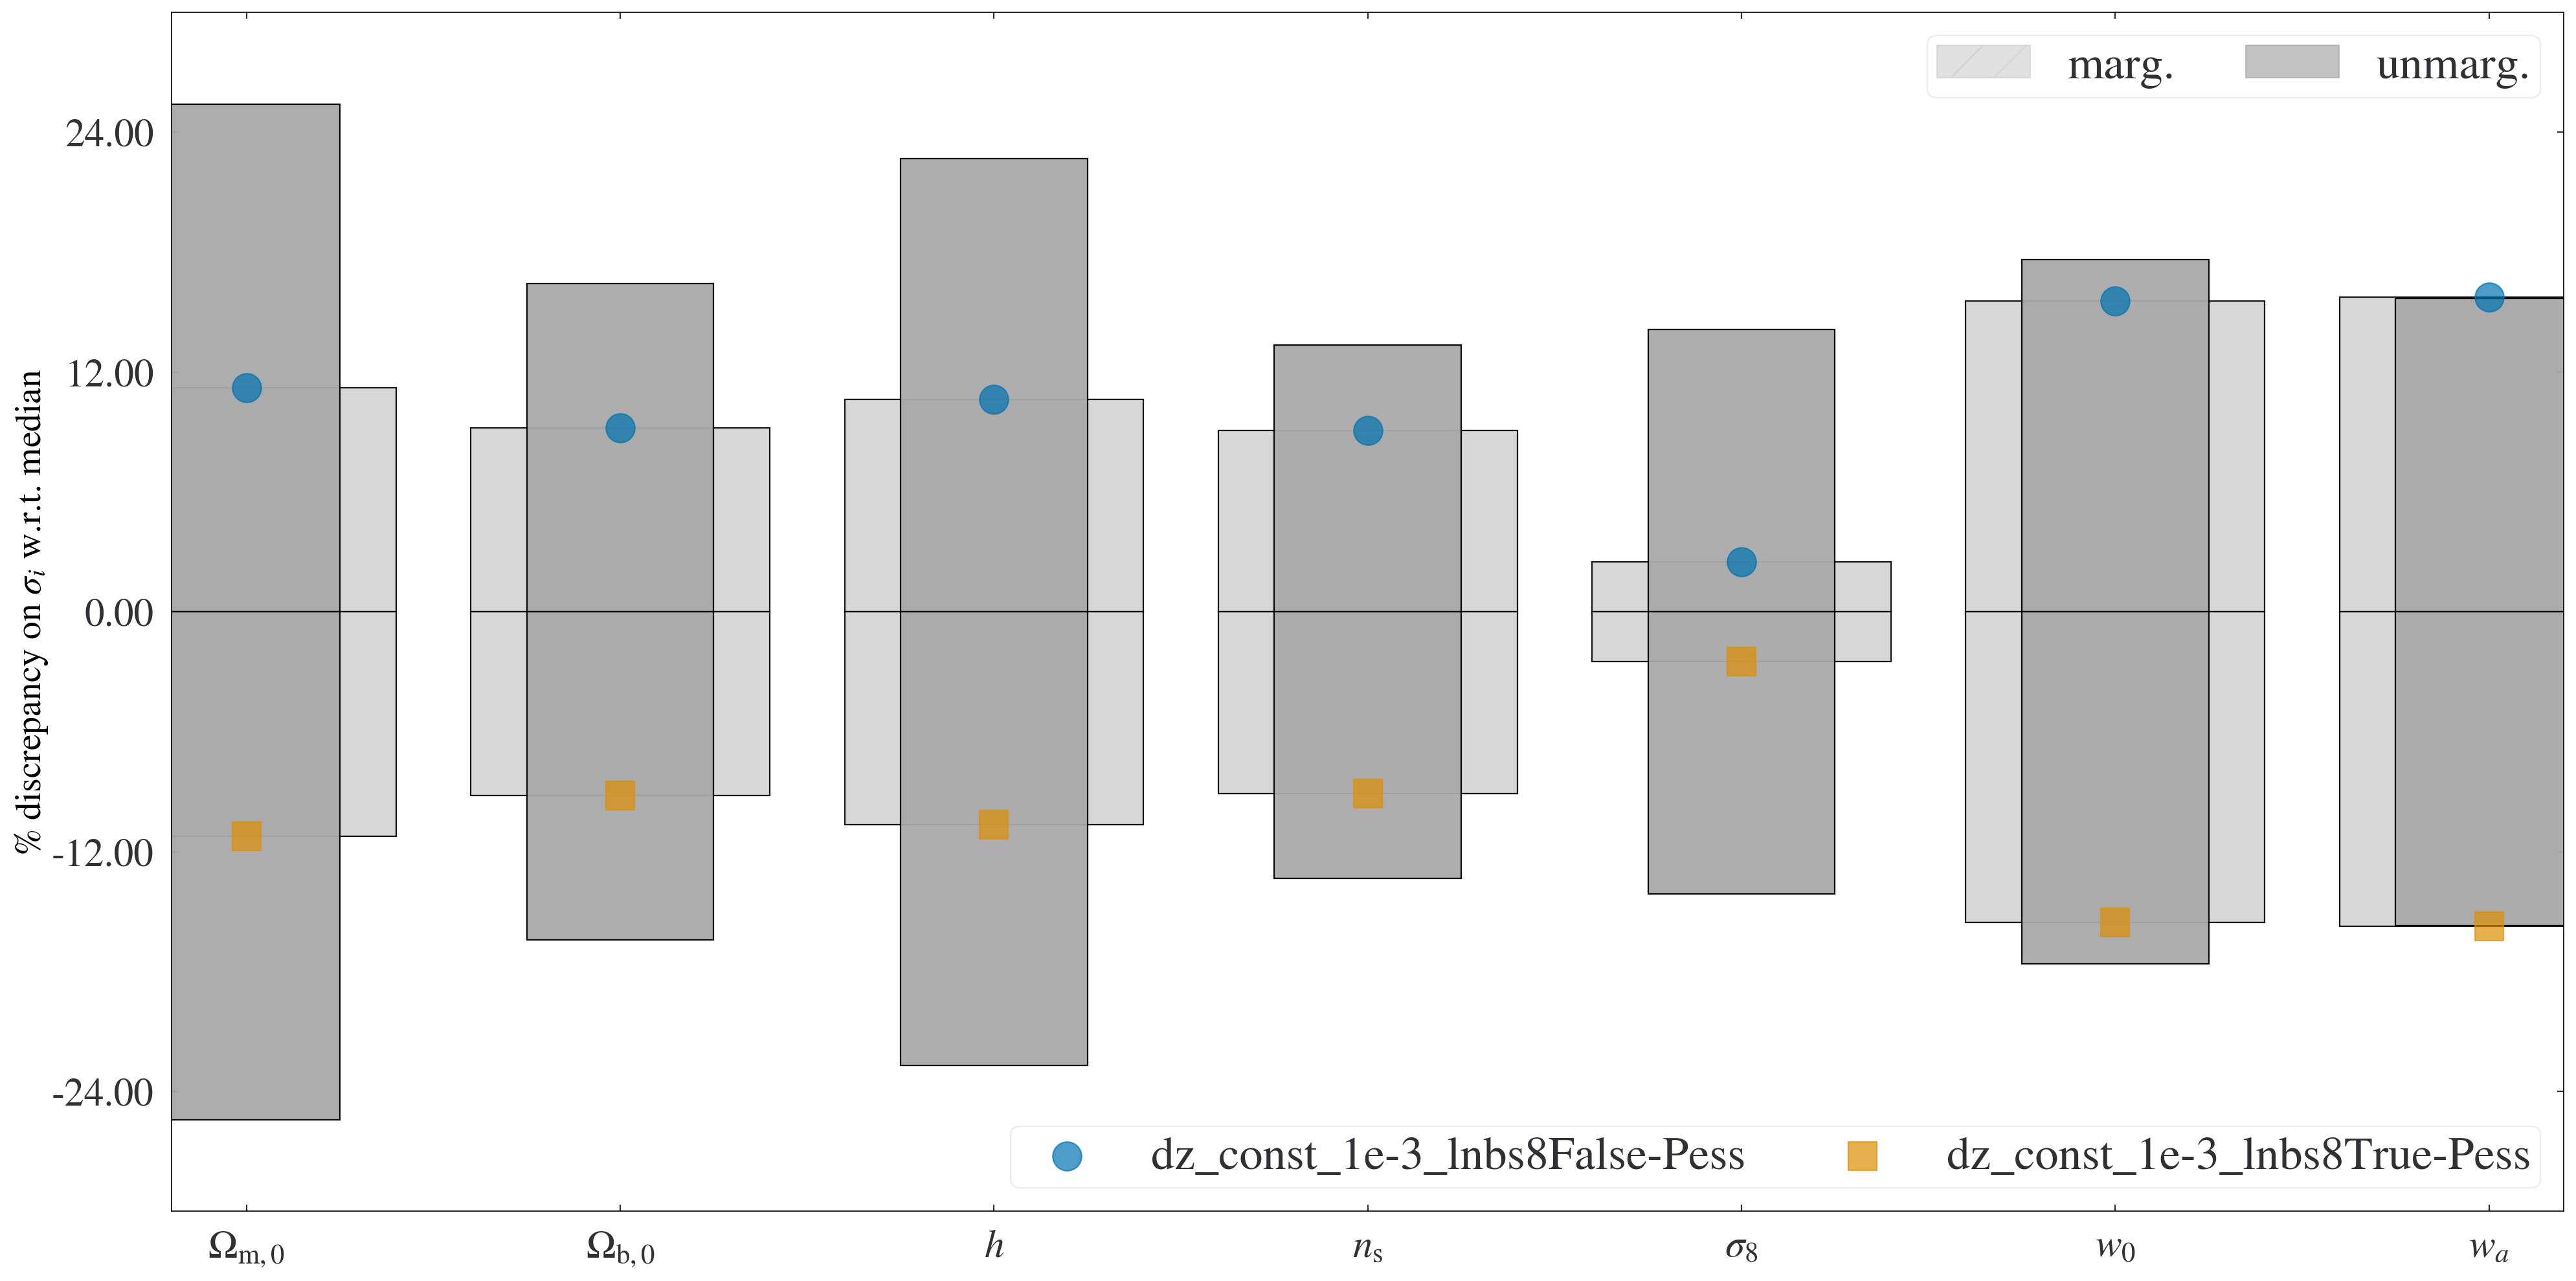

In [57]:
choosetoplot = [0,1]
plot_options = {'fishers_list': [fishers_list[ii] for ii in choosetoplot], 
                'colors': [snscolors[ii] for ii in choosetoplot],
                'fish_labels' : [labels_list[ii] for ii in choosetoplot],
                'plot_pars': pars,
                'axis_custom_factors': {'all':6},  ## Axis limits cover 3-sigma bounds of first Fisher matrix
                'plot_method': 'Gaussian',
                'file_format': '.pdf',   ##file format for all the plots
                'outpath' : './plots/',  ## directory where to store the files, if non-existent, it will be created
                'outroot': plotoutroot  ## file name root for all the plots, extra names can be added individually
          } 
fish_plotter = fpp.fisher_plotting(**plot_options)
fish_plotter.load_gaussians()
fish_plotter.compare_errors({'save_error':True, 'dotlegend_fontsize':11, 'yrang': [-30,30], 'ncol_legend' : 2})

Entering plotting routine
{'Omegam': [0.23535353198510006, 0.40464646801489995], 'Omegab': [0.03759719793475134, 0.06240280206524867], 'h': [0.557923531542434, 0.7820764684575661], 'ns': [0.8845715367571387, 1.0354284632428612], 'sigma8': [0.7289041353449806, 0.9022638646550194], 'w0': [-1.7122854332890578, -0.2877145667109422], 'wa': [-2.1097403071611707, 2.1097403071611707], 'lnbg_1': [0.3554935015257771, 0.40340649847422294], 'lnbg_2': [0.44848150689625865, 0.49913049310374136], 'lnbg_3': [0.5310294185632289, 0.5841745814367711], 'lnbg_4': [0.6133249430654812, 0.6691890569345187], 'Ps_1': [-74.44997256355259, 74.44997256355259], 'Ps_2': [-74.89376158051229, 74.89376158051229], 'Ps_3': [-78.3569128977062, 78.3569128977062], 'Ps_4': [-79.51447686181945, 79.51447686181945]}


/home/santiago/CosmoProjects/cosmicfish_release/cosmicfishpie/cosmicfishpie/analysis/fisher_plotting.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.savefig(
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


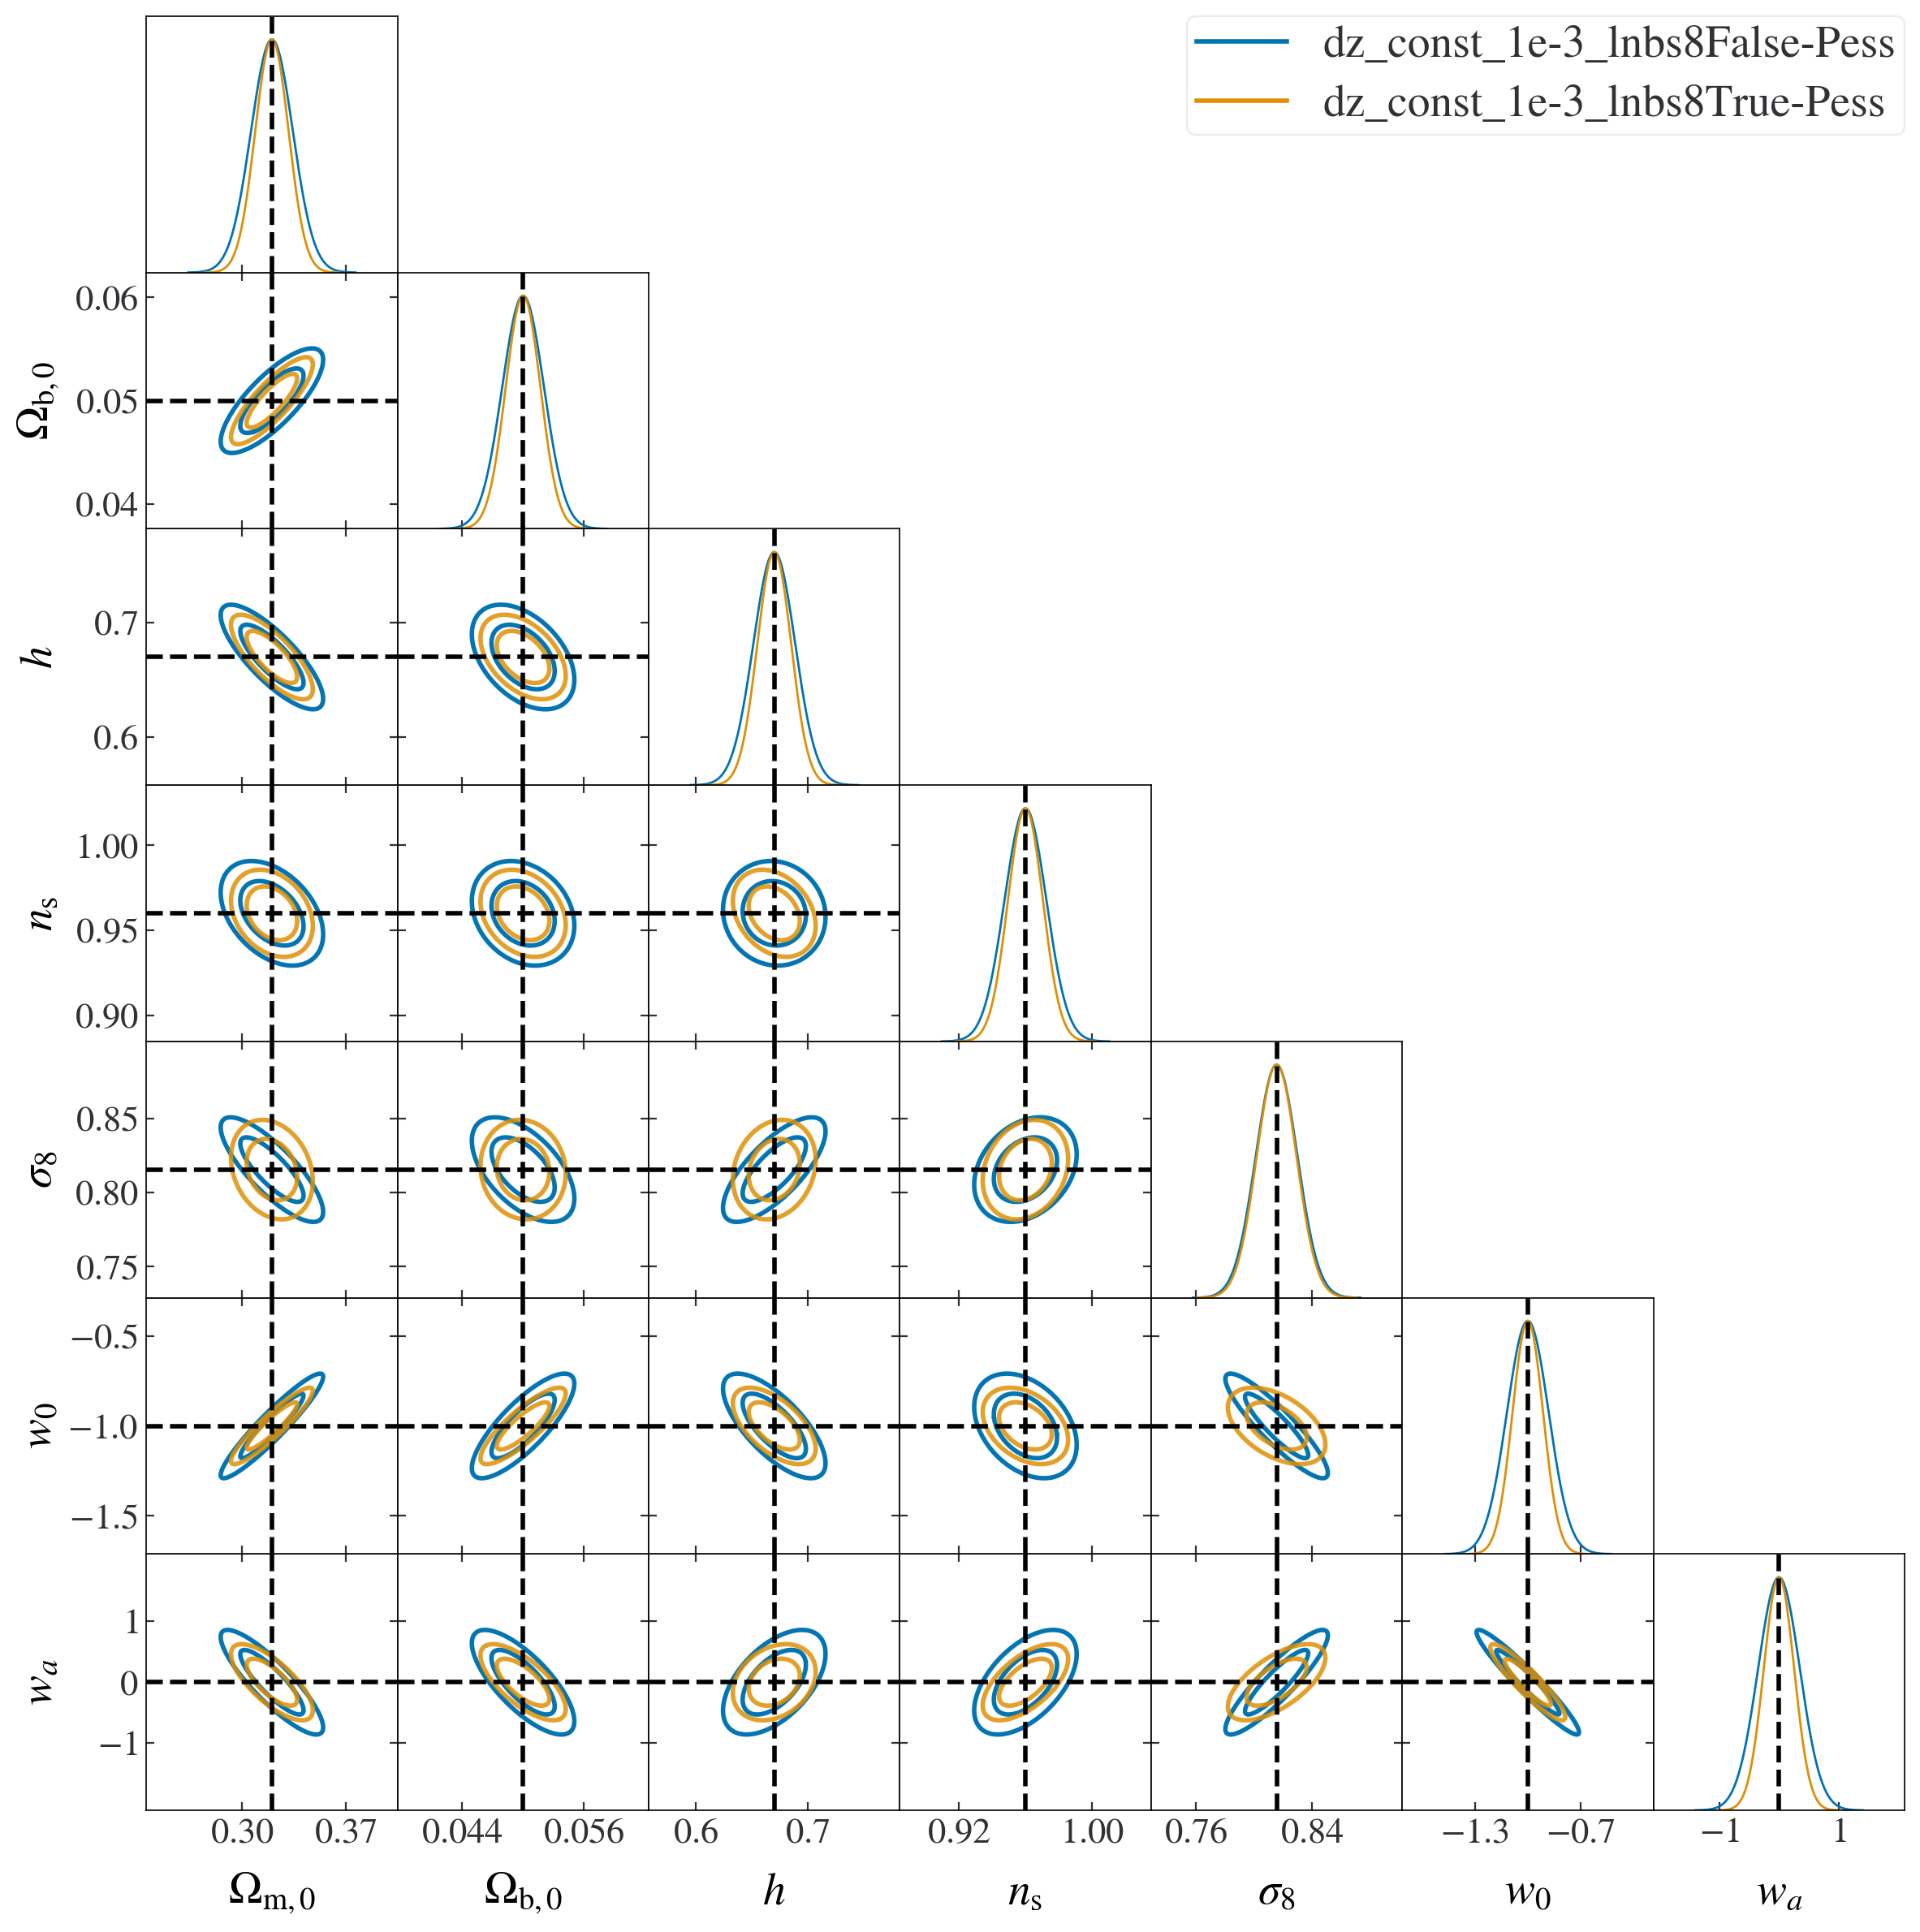

In [58]:
fish_plotter.plot_fisher(filled=False, contour_args=[{'alpha':0.99, 'ls': '-', 'lw':2.}, 
                                                    {'alpha':0.85, 'ls' : '-', 'lw':2.},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.5},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.}
                                                    ])

In [67]:
fishers_list_gitlab = glob.glob('../../cosmicfish_reloaded_gitlab/notebooks/results_FINAL_test/'+'*1*w0waCDM*cambfiles*GCsp*fishermatrix.txt')
fishers_list_gitlab.sort()
fishers_list_gitlab

['../../cosmicfish_reloaded_gitlab/notebooks/results_FINAL_test/CosmicFish_v1.0_w0waCDM-GCsp-ext_cambfiles-TESTS--dztype_constant-dz_0.0010-Euclid-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 '../../cosmicfish_reloaded_gitlab/notebooks/results_FINAL_test/CosmicFish_v1.0_w0waCDM-GCsp-ext_cambfiles-TESTS--dztype_constant-dz_0.0010-Euclid-ISTF-Pessimistic_GCsp_fishermatrix.txt',
 '../../cosmicfish_reloaded_gitlab/notebooks/results_FINAL_test/CosmicFish_v1.0_w0waCDM-GCsp-ext_cambfiles-TESTS--dztype_constant-dz_0.0020-Euclid-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 '../../cosmicfish_reloaded_gitlab/notebooks/results_FINAL_test/CosmicFish_v1.0_w0waCDM-GCsp-ext_cambfiles-TESTS--dztype_constant-dz_0.0020-Euclid-ISTF-Pessimistic_GCsp_fishermatrix.txt']

In [68]:
fishes_gitlab = [fm.fisher_matrix(file_name=fi) for fi in fishers_list_gitlab[0:2]]
#fishes_gitlab[0].get_param_names()
fishers_list_gitlab = fishes_gitlab
labels_list_gitlab = [
               'dz_const_1e-3_lnbs8False-Pess-Gitlab',
               'dz_const_1e-3_lnbs8True-Pess-Gitlab',
               ]
labels_list_gitlab
for iii, lala in enumerate(labels_list_gitlab):
    print("ii={:d}, lab: {:s}".format(iii, lala))

ii=0, lab: dz_const_1e-3_lnbs8False-Pess-Gitlab
ii=1, lab: dz_const_1e-3_lnbs8True-Pess-Gitlab


In [70]:
fishers_tabulate = fishers_list[0:1] + fishers_list_gitlab
labels_tabulate = labels_list[0:1] + labels_list_gitlab
for ii, fish in enumerate(fishers_tabulate):
    print("Fisher Name: ", fish.name)
    print("Label: ", labels_tabulate[ii])
    sigmas = fish.get_confidence_bounds()
    fidus = fish.get_param_fiducial()
    for ii, par in enumerate(cosmoparnames):
        print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))

Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0141, percent error: 4.4%
Parameter Omegab,  fiducial: 0.050, 1-sigma error: 0.0021, percent error: 4.1%
Parameter h,  fiducial: 0.670, 1-sigma error: 0.0187, percent error: 2.8%
Parameter ns,  fiducial: 0.960, 1-sigma error: 0.0126, percent error: 1.3%
Parameter sigma8,  fiducial: 0.816, 1-sigma error: 0.0144, percent error: 1.8%
Parameter w0,  fiducial: -1.000, 1-sigma error: 0.1187, percent error: 11.9%
Parameter wa,  fiducial: 0.000, 1-sigma error: 0.3516, percent error: inf%
Fisher Name:  CosmicFish_v1.0_w0waCDM-GCsp-ext_cambfiles-TESTS--dztype_constant-dz_0.0010-Euclid-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8False-Pess-Gitlab
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0141, percent error: 4.4%
Parame

/tmp/ipykernel_1820376/3996437141.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))


./plots  exists already
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8False-Pess-Gitlab
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8True-Pess-Gitlab
('Fishers names: ', ['dz_const_1e-3_lnbs8False-Pess', 'dz_const_1e-3_lnbs8False-Pess-Gitlab', 'dz_const_1e-3_lnbs8True-Pess-Gitlab'])
('parameters to plot: ', ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa'])
X tick labels ---> :   ['\\Omega_{{\\rm m}, 0}', '\\Omega_{{\\rm b}, 0}', 'h', 'n_{\\rm s}', '\\sigma_8', 'w_0', 'w_a']


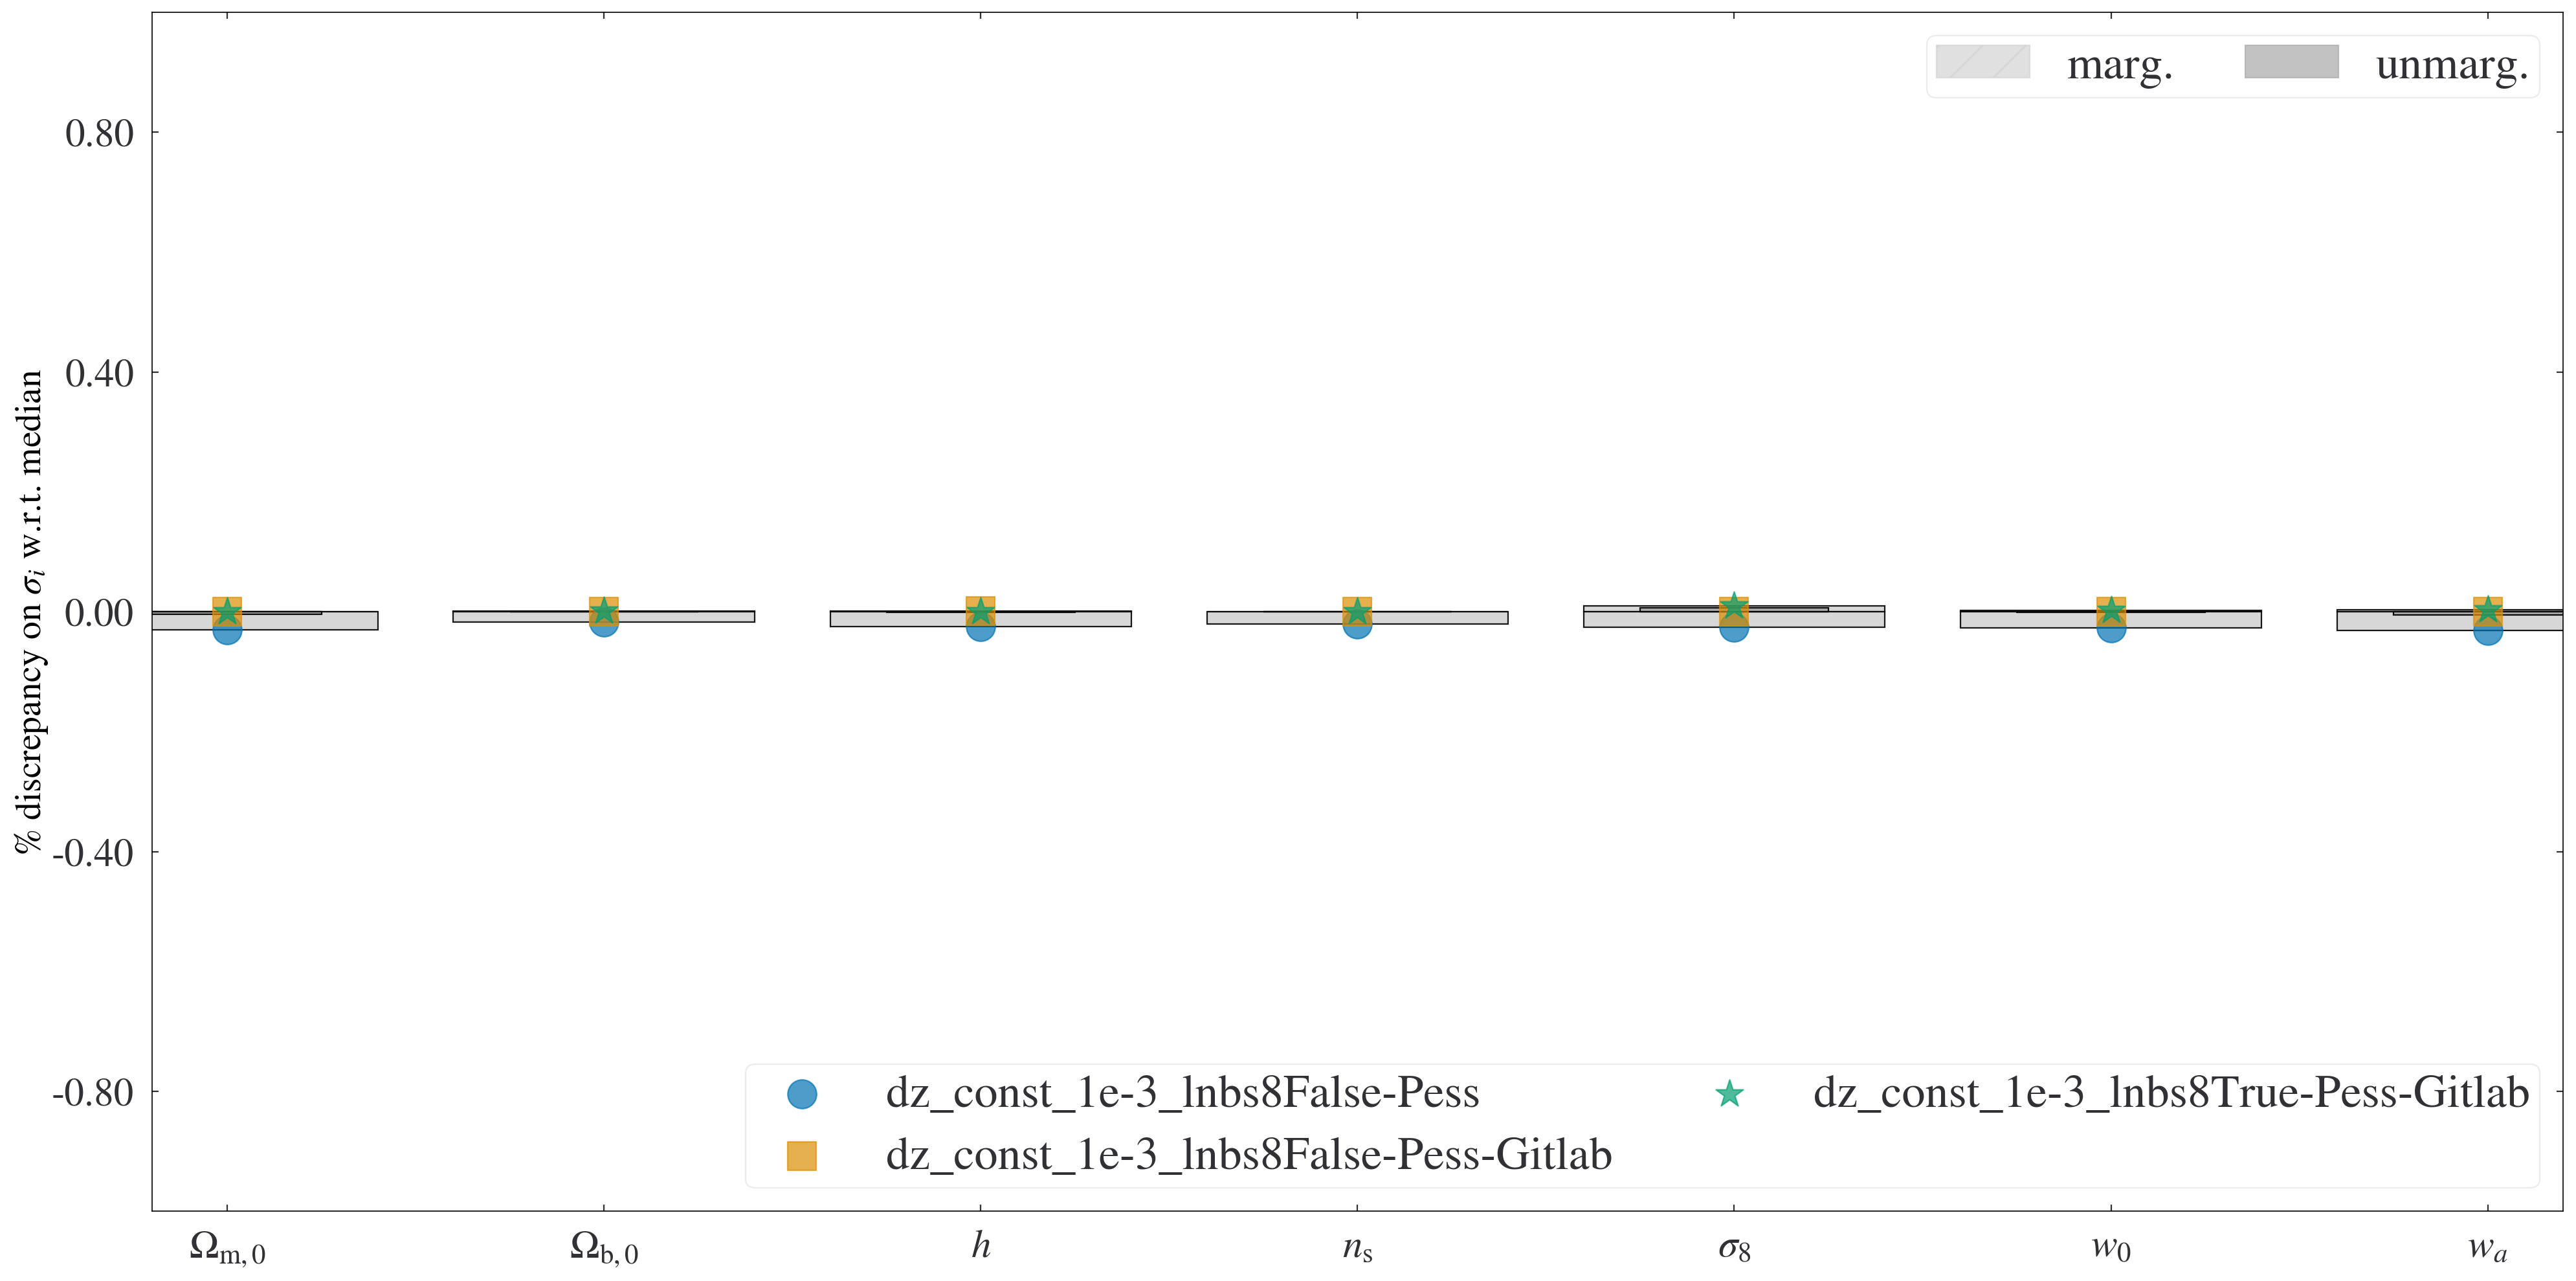

In [72]:
choosetoplot = [0,1,2]
plot_options = {'fishers_list': [fishers_tabulate[ii] for ii in choosetoplot], 
                'colors': [snscolors[ii] for ii in choosetoplot],
                'fish_labels' : [labels_tabulate[ii] for ii in choosetoplot],
                'plot_pars': pars,
                'axis_custom_factors': {'all':6},  ## Axis limits cover 3-sigma bounds of first Fisher matrix
                'plot_method': 'Gaussian',
                'file_format': '.pdf',   ##file format for all the plots
                'outpath' : './plots/',  ## directory where to store the files, if non-existent, it will be created
                'outroot': plotoutroot  ## file name root for all the plots, extra names can be added individually
          } 
fish_plotter = fpp.fisher_plotting(**plot_options)
fish_plotter.load_gaussians()
fish_plotter.compare_errors({'save_error':True, 'dotlegend_fontsize':11, 'yrang': [-1,1], 'ncol_legend' : 2})

## Plot the resulting Fisher matrices with sigma_pv

In [73]:
from cosmicfishpie.analysis import fisher_plotting as fpp
from cosmicfishpie.analysis import fisher_matrix as fm
from cosmicfishpie.analysis import fisher_operations as fo
from cosmicfishpie.analysis import fisher_plot_analysis as fa
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('../scripts/plot-style.txt')
snscolors=sns.color_palette("colorblind")
snscolors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [74]:
fiducial = {"Omegam":0.32,
            "Omegab":0.05,
            "h":0.67,
            "ns":0.96,          ## Fiducial values of the cosmological parameters
            "sigma8":0.815584,
            "w0":-1.0,
            "wa":0.
            }

In [75]:
cosmoparnames = list(fiducial.keys())
cosmoparnames

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']

In [76]:
filelist = glob.glob(options['results_dir']+'*1*w0waCDM*cambfiles*GCsp*fishermatrix.txt')
filelist.sort()
filelist_filter = [fi for fi in filelist if 'bfs8False' in fi]
filelist_filter

['./results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles-sigma_pv--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles-sigma_pv--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv-bfs8False_GCsp_fishermatrix.txt']

In [77]:
fishes = [fm.fisher_matrix(file_name=fi) for fi in filelist_filter]

In [78]:
pars = fishes[0].get_param_names()[:7]
print(pars)

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']


In [79]:
fishers_list = fishes
labels_list = [
               'dz_const_1e-3_lnbs8False-Pess',
               'dz_const_2e-3_lnbs8False-Pess',
               'dz_const_1e-3-sigmapv_lnbs8False-Pess',
               'dz_const_2e-3-sigmapv_lnbs8False-Pess',
               ]
labels_list
for iii, lala in enumerate(labels_list):
    print("ii={:d}, lab: {:s}".format(iii, lala))

ii=0, lab: dz_const_1e-3_lnbs8False-Pess
ii=1, lab: dz_const_2e-3_lnbs8False-Pess
ii=2, lab: dz_const_1e-3-sigmapv_lnbs8False-Pess
ii=3, lab: dz_const_2e-3-sigmapv_lnbs8False-Pess


In [80]:
plotoutroot = ''.join(list(set(''.join(labels_list))))
plotoutroot

'a2igbz_ceotmn1lv-Pp8s3dF'

In [81]:
fishers_tabulate = fishers_list
for ii, fish in enumerate(fishers_tabulate):
    print("Fisher Name: ", fish.name)
    print("Label: ", labels_list[ii])
    sigmas = fish.get_confidence_bounds()
    fidus = fish.get_param_fiducial()
    for ii, par in enumerate(cosmoparnames):
        print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))

Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0141, percent error: 4.4%
Parameter Omegab,  fiducial: 0.050, 1-sigma error: 0.0021, percent error: 4.1%
Parameter h,  fiducial: 0.670, 1-sigma error: 0.0187, percent error: 2.8%
Parameter ns,  fiducial: 0.960, 1-sigma error: 0.0126, percent error: 1.3%
Parameter sigma8,  fiducial: 0.816, 1-sigma error: 0.0144, percent error: 1.8%
Parameter w0,  fiducial: -1.000, 1-sigma error: 0.1187, percent error: 11.9%
Parameter wa,  fiducial: 0.000, 1-sigma error: 0.3516, percent error: inf%
Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_2e-3_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0151, percent error: 4.7%
Par

/tmp/ipykernel_1820376/3027638779.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))


./plots  exists already
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_2e-3_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_1e-3-sigmapv_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_2e-3-sigmapv_lnbs8False-Pess
('Fishers names: ', ['dz_const_1e-3_lnbs8False-Pess', 'dz_const_2e-3_lnbs8False-Pess', 'dz_const_1e-3-sigmapv_lnbs8False-Pess', 'dz_const_2e-3-sigmapv_lnbs8False-Pess'])
('parameters to plot: ', ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa'])
X tick labels ---> :   ['\\Omega_{{\\rm m}, 0}', '\\Omega_{{\\rm b}, 0}', 'h', 'n_{\\rm s}', '\\sigma_8', 'w_0', 'w_a']


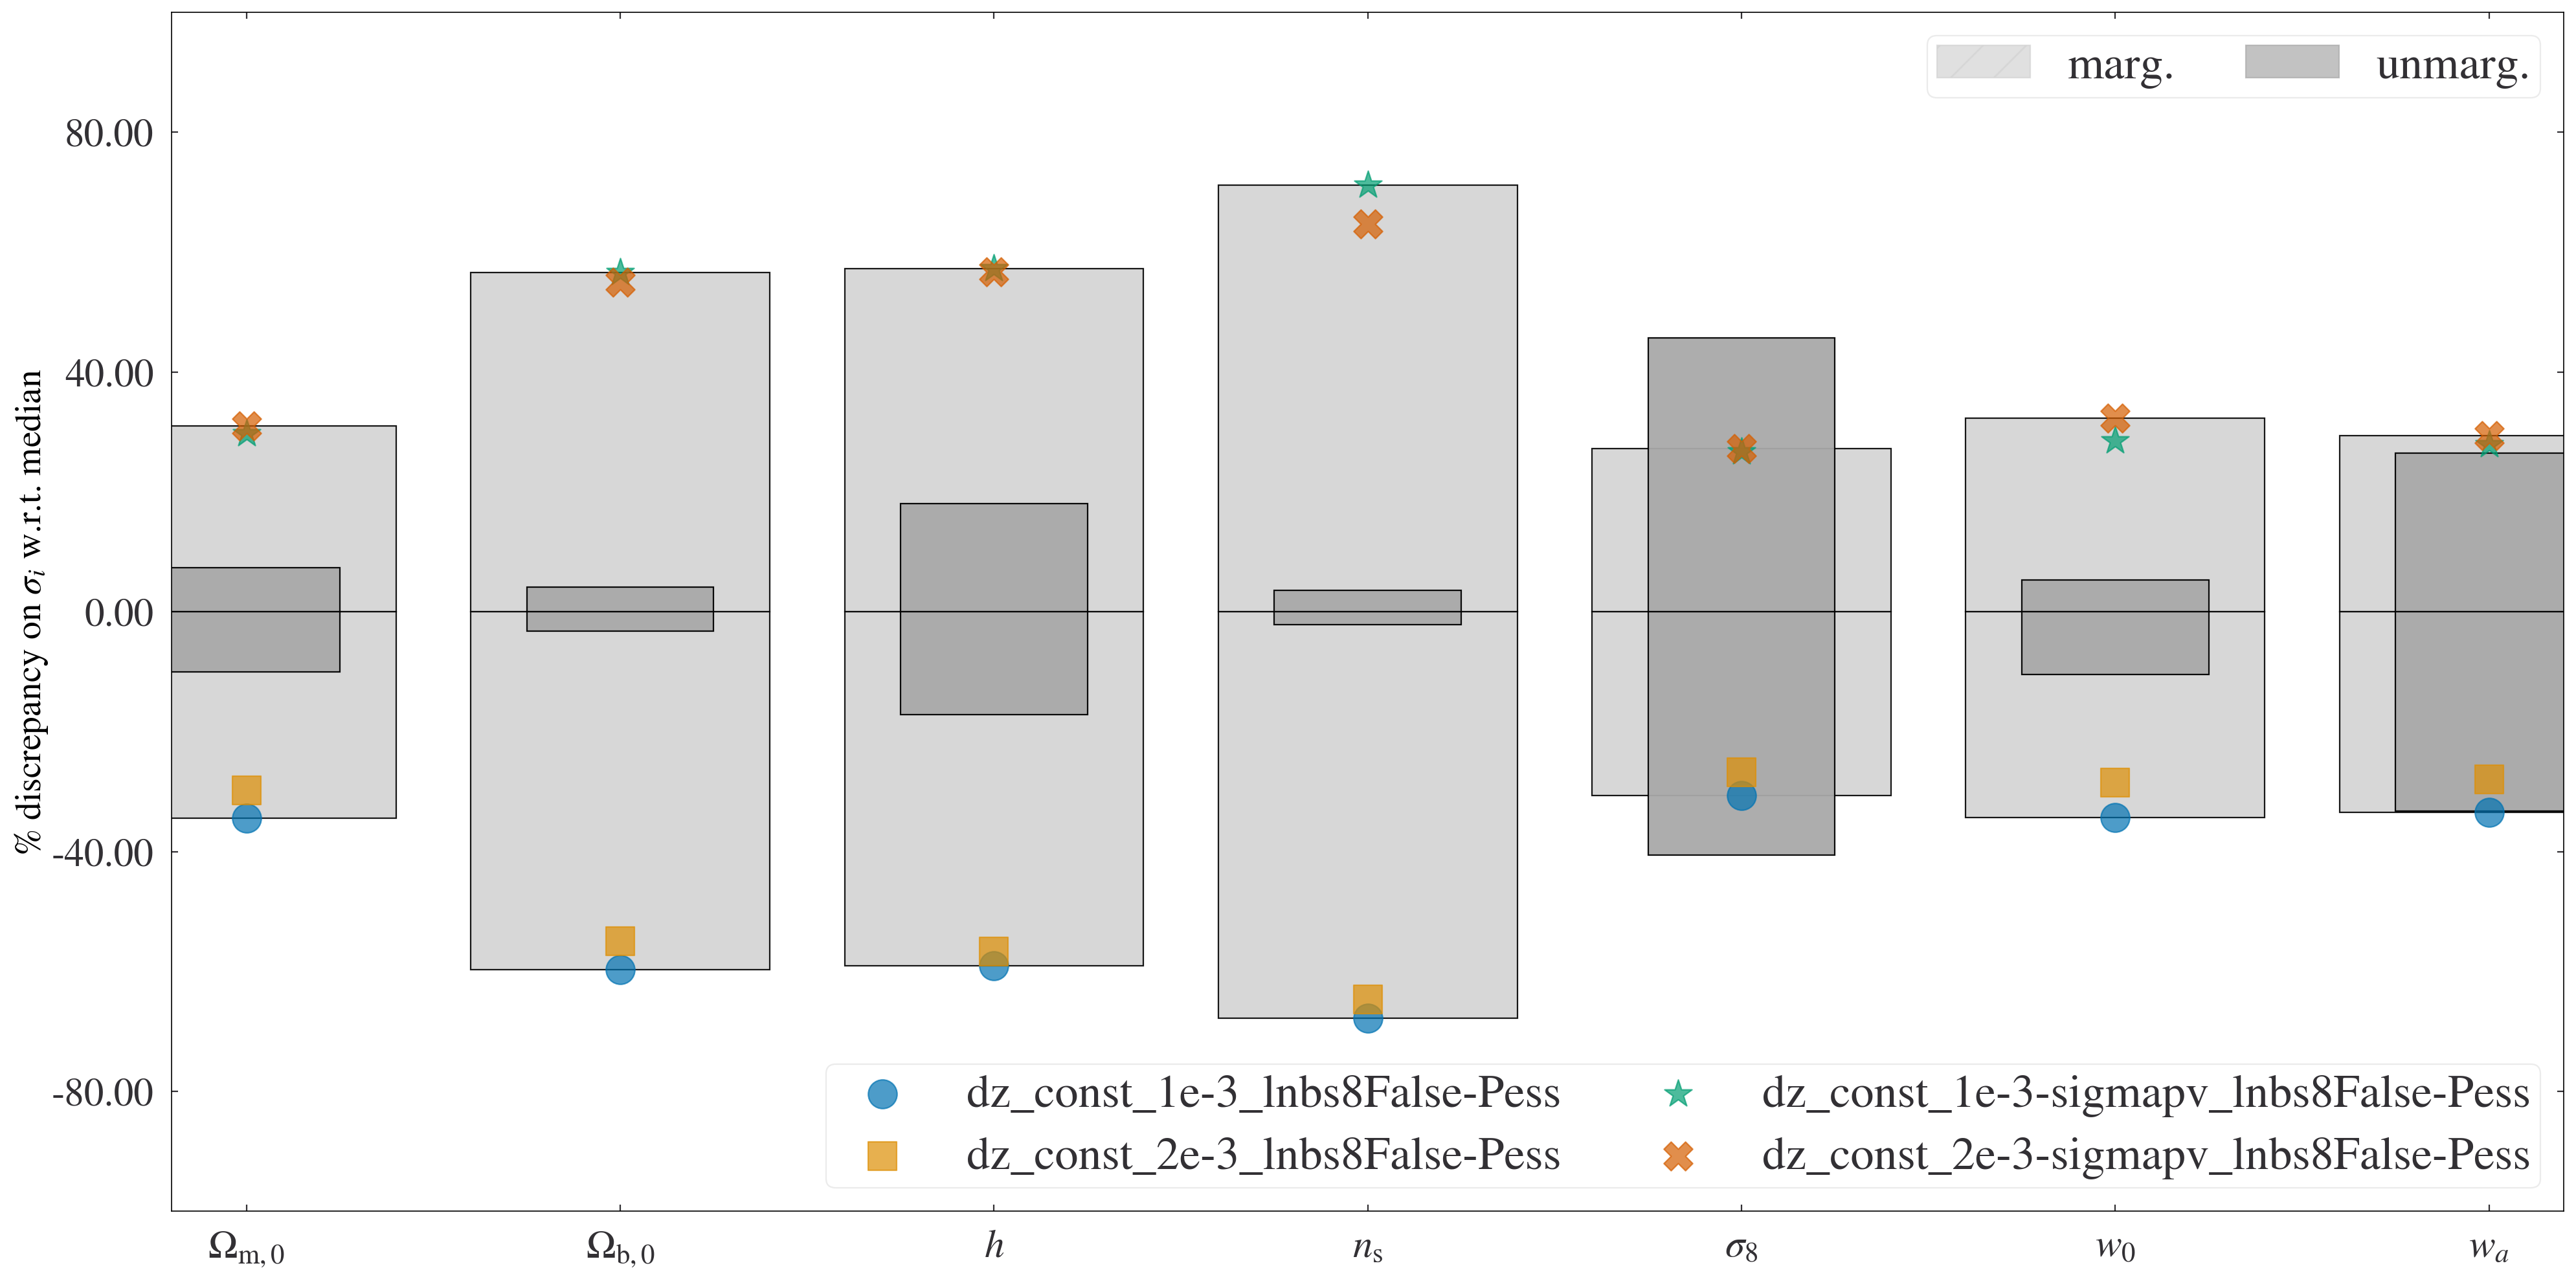

In [82]:
choosetoplot = [0,1,2,3]
plot_options = {'fishers_list': [fishers_list[ii] for ii in choosetoplot], 
                'colors': [snscolors[ii] for ii in choosetoplot],
                'fish_labels' : [labels_list[ii] for ii in choosetoplot],
                'plot_pars': pars,
                'axis_custom_factors': {'all':6},  ## Axis limits cover 3-sigma bounds of first Fisher matrix
                'plot_method': 'Gaussian',
                'file_format': '.pdf',   ##file format for all the plots
                'outpath' : './plots/',  ## directory where to store the files, if non-existent, it will be created
                'outroot': plotoutroot  ## file name root for all the plots, extra names can be added individually
          } 
fish_plotter = fpp.fisher_plotting(**plot_options)
fish_plotter.load_gaussians()
fish_plotter.compare_errors({'save_error':True, 'dotlegend_fontsize':11, 'yrang': [-100,100], 'ncol_legend' : 2})

Entering plotting routine
{'Omegam': [0.23535353198510006, 0.40464646801489995], 'Omegab': [0.03759719793475134, 0.06240280206524867], 'h': [0.557923531542434, 0.7820764684575661], 'ns': [0.8845715367571387, 1.0354284632428612], 'sigma8': [0.7289041353449806, 0.9022638646550194], 'w0': [-1.7122854332890578, -0.2877145667109422], 'wa': [-2.1097403071611707, 2.1097403071611707], 'lnbg_1': [0.3554935015257771, 0.40340649847422294], 'lnbg_2': [0.44848150689625865, 0.49913049310374136], 'lnbg_3': [0.5310294185632289, 0.5841745814367711], 'lnbg_4': [0.6133249430654812, 0.6691890569345187], 'Ps_1': [-74.44997256355259, 74.44997256355259], 'Ps_2': [-74.89376158051229, 74.89376158051229], 'Ps_3': [-78.3569128977062, 78.3569128977062], 'Ps_4': [-79.51447686181945, 79.51447686181945]}


/home/santiago/CosmoProjects/cosmicfish_release/cosmicfishpie/cosmicfishpie/analysis/fisher_plotting.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.savefig(
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


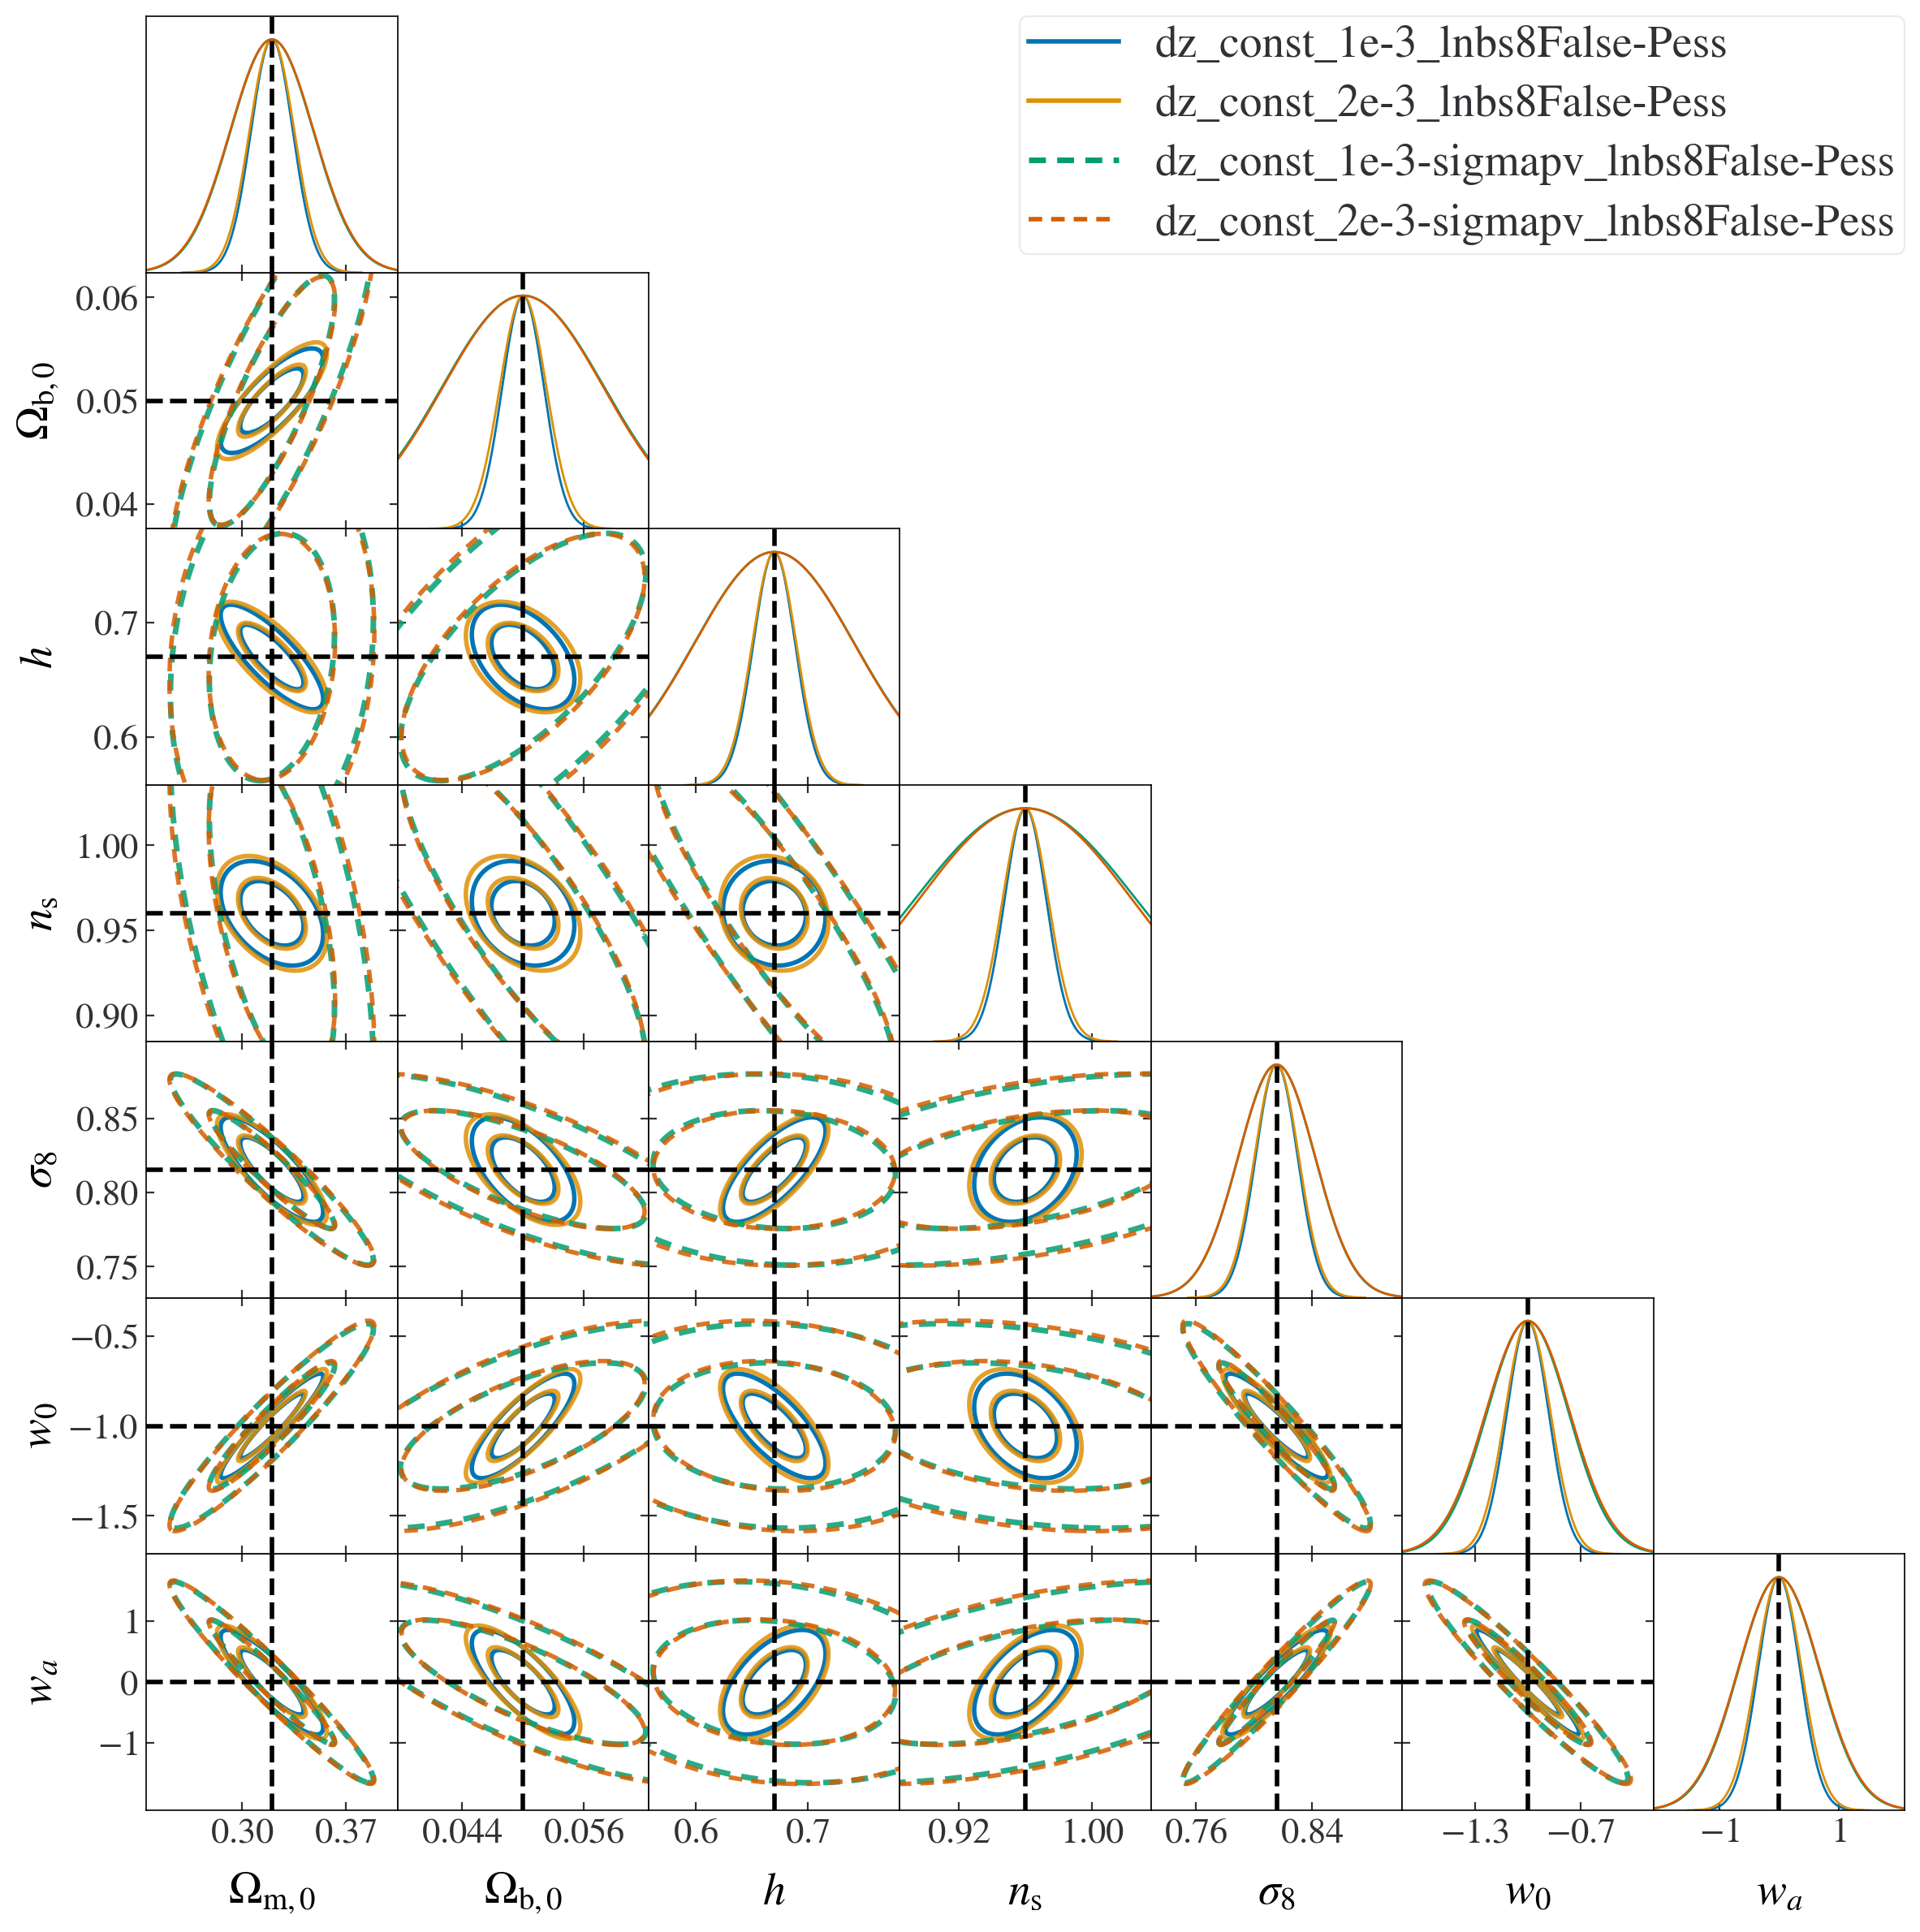

In [83]:
fish_plotter.plot_fisher(filled=False, contour_args=[{'alpha':0.99, 'ls': '-', 'lw':2.}, 
                                                    {'alpha':0.85, 'ls' : '-', 'lw':2.},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.5},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.}
                                                    ])

## Plot the resulting Fisher matrices fixing sigma_pv

In [84]:
from cosmicfishpie.analysis import fisher_plotting as fpp
from cosmicfishpie.analysis import fisher_matrix as fm
from cosmicfishpie.analysis import fisher_operations as fo
from cosmicfishpie.analysis import fisher_plot_analysis as fa
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('../scripts/plot-style.txt')
snscolors=sns.color_palette("colorblind")
snscolors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [85]:
fiducial = {"Omegam":0.32,
            "Omegab":0.05,
            "h":0.67,
            "ns":0.96,          ## Fiducial values of the cosmological parameters
            "sigma8":0.815584,
            "w0":-1.0,
            "wa":0.
            }

In [86]:
cosmoparnames = list(fiducial.keys())
cosmoparnames

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']

In [87]:
filelist = glob.glob(options['results_dir']+'*1*w0waCDM*cambfiles*GCsp*fishermatrix.txt')
filelist.sort()
filelist_filter = [fi for fi in filelist if 'bfs8False' in fi]
filelist_filter

['./results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles-sigma_pv--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv-bfs8False_GCsp_fishermatrix.txt',
 './results_FINAL_test_gitlab/CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles-sigma_pv--dztype_constant-dz_0.0020-Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv-bfs8False_GCsp_fishermatrix.txt']

In [88]:
fishes = [fm.fisher_matrix(file_name=fi) for fi in filelist_filter]

In [89]:
standard_pars = fishes[0].get_param_names()
standard_pars

['Omegam',
 'Omegab',
 'h',
 'ns',
 'sigma8',
 'w0',
 'wa',
 'lnbg_1',
 'lnbg_2',
 'lnbg_3',
 'lnbg_4',
 'Ps_1',
 'Ps_2',
 'Ps_3',
 'Ps_4']

In [90]:
extended_pars = fishes[2].get_param_names()
extended_pars

['Omegam',
 'Omegab',
 'h',
 'ns',
 'sigma8',
 'w0',
 'wa',
 'lnbg_1',
 'lnbg_2',
 'lnbg_3',
 'lnbg_4',
 'Ps_1',
 'Ps_2',
 'Ps_3',
 'Ps_4',
 'sigmap_1',
 'sigmap_2',
 'sigmap_3',
 'sigmap_4',
 'sigmav_1',
 'sigmav_2',
 'sigmav_3',
 'sigmav_4']

In [91]:
pars = fishes[0].get_param_names()[:7]
print(pars)

['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa']


In [94]:
fish_fix = fo.reshuffle(fishes[2], standard_pars, update_names=True)
fishes[2] = fish_fix

In [95]:
fishers_list = [fishes[ii] for ii in [0,2]]
labels_list = [
               'dz_const_1e-3_lnbs8False-Pess',
               'dz_const_1e-3-fix_sigmapv_lnbs8False-Pess',
               ]
labels_list
for iii, lala in enumerate(labels_list):
    print("ii={:d}, lab: {:s}".format(iii, lala))

ii=0, lab: dz_const_1e-3_lnbs8False-Pess
ii=1, lab: dz_const_1e-3-fix_sigmapv_lnbs8False-Pess


In [96]:
plotoutroot = ''.join(list(set(''.join(labels_list))))
plotoutroot

'aigbz_ceotmn1lfv-Pp8sx3dF'

In [97]:
fishers_tabulate = fishers_list
for ii, fish in enumerate(fishers_tabulate):
    print("Fisher Name: ", fish.name)
    print("Label: ", labels_list[ii])
    sigmas = fish.get_confidence_bounds()
    fidus = fish.get_param_fiducial()
    for ii, par in enumerate(cosmoparnames):
        print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))

Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-bfs8False_GCsp_fishermatrix
Label:  dz_const_1e-3_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sigma error: 0.0141, percent error: 4.4%
Parameter Omegab,  fiducial: 0.050, 1-sigma error: 0.0021, percent error: 4.1%
Parameter h,  fiducial: 0.670, 1-sigma error: 0.0187, percent error: 2.8%
Parameter ns,  fiducial: 0.960, 1-sigma error: 0.0126, percent error: 1.3%
Parameter sigma8,  fiducial: 0.816, 1-sigma error: 0.0144, percent error: 1.8%
Parameter w0,  fiducial: -1.000, 1-sigma error: 0.1187, percent error: 11.9%
Parameter wa,  fiducial: 0.000, 1-sigma error: 0.3516, percent error: inf%
Fisher Name:  CosmicFish_v1.2.3_w0waCDM-GCsp-ext_cambfiles-sigma_pv--dztype_constant-dz_0.0010-Euclid-Spectroscopic-ISTF-Pessimistic-sigma_pv-bfs8False_GCsp_fishermatrix_reshuffled
Label:  dz_const_1e-3-fix_sigmapv_lnbs8False-Pess
Parameter Omegam,  fiducial: 0.320, 1-sig

/tmp/ipykernel_1820376/3027638779.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  print("Parameter {:s},  fiducial: {:.3f}, 1-sigma error: {:.4f}, percent error: {:.1f}%".format(par, fidus[ii], abs(sigmas[ii]), abs(100*sigmas[ii]/fidus[ii])))


./plots  exists already
Fisher matrix loaded, label name:  dz_const_1e-3_lnbs8False-Pess
Fisher matrix loaded, label name:  dz_const_1e-3-fix_sigmapv_lnbs8False-Pess
('Fishers names: ', ['dz_const_1e-3_lnbs8False-Pess', 'dz_const_1e-3-fix_sigmapv_lnbs8False-Pess'])
('parameters to plot: ', ['Omegam', 'Omegab', 'h', 'ns', 'sigma8', 'w0', 'wa'])
X tick labels ---> :   ['\\Omega_{{\\rm m}, 0}', '\\Omega_{{\\rm b}, 0}', 'h', 'n_{\\rm s}', '\\sigma_8', 'w_0', 'w_a']


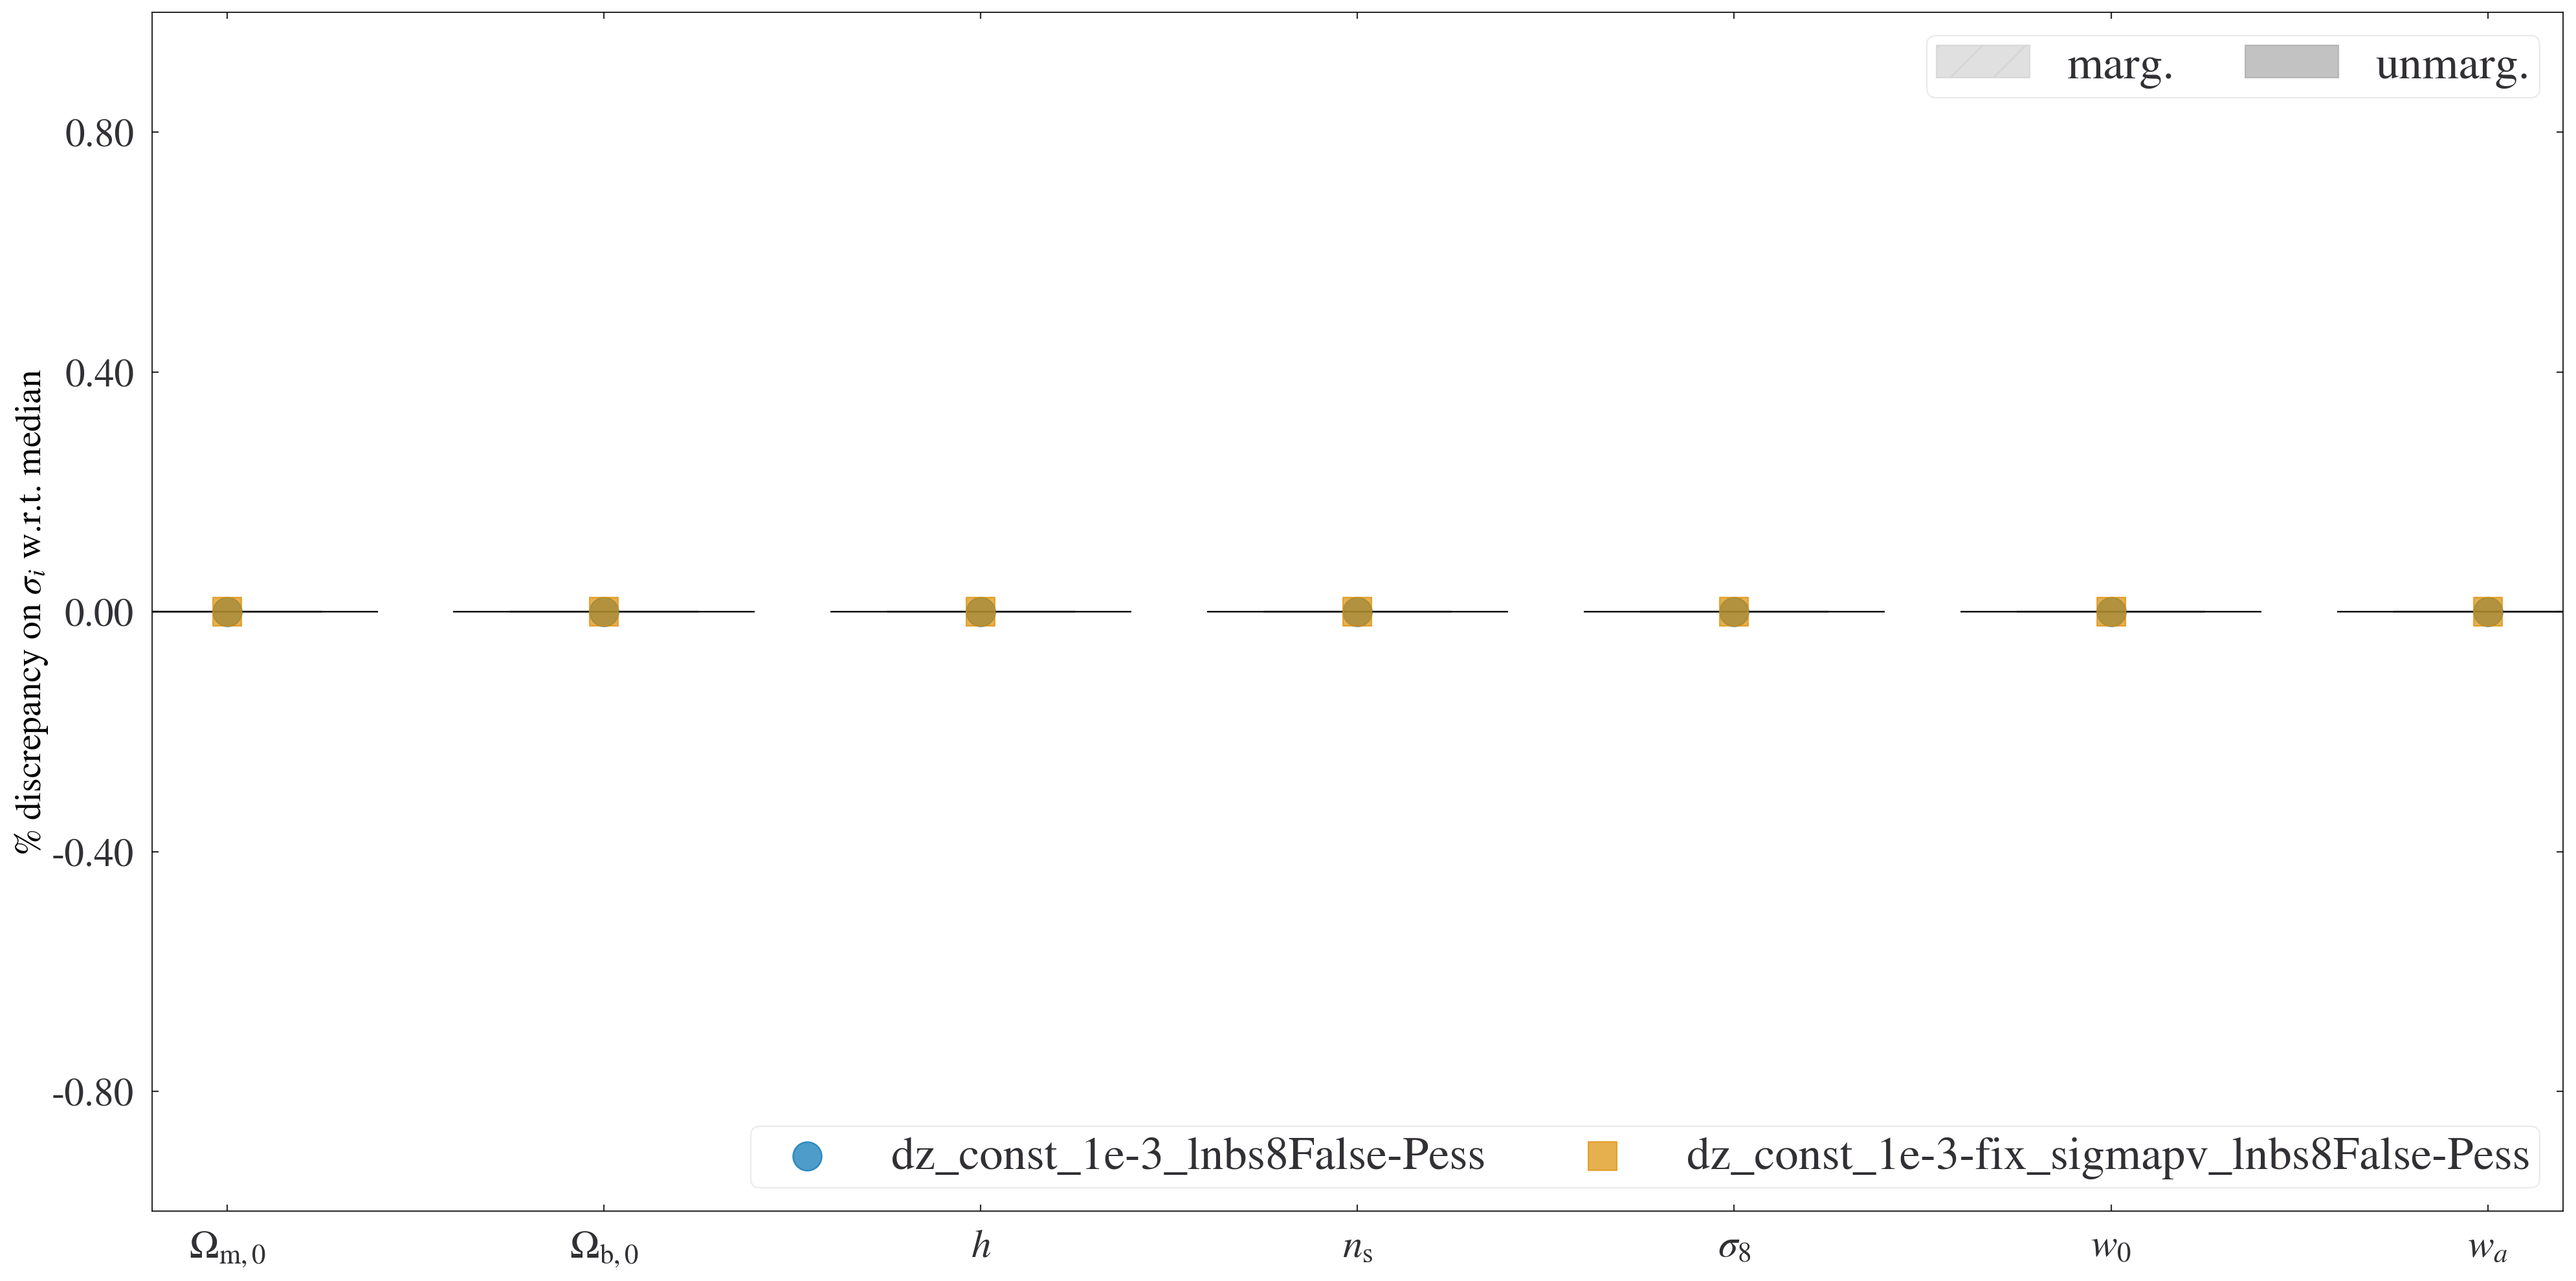

In [99]:
choosetoplot = [0,1]
plot_options = {'fishers_list': [fishers_list[ii] for ii in choosetoplot], 
                'colors': [snscolors[ii] for ii in choosetoplot],
                'fish_labels' : [labels_list[ii] for ii in choosetoplot],
                'plot_pars': pars,
                'axis_custom_factors': {'all':6},  ## Axis limits cover 3-sigma bounds of first Fisher matrix
                'plot_method': 'Gaussian',
                'file_format': '.pdf',   ##file format for all the plots
                'outpath' : './plots/',  ## directory where to store the files, if non-existent, it will be created
                'outroot': plotoutroot  ## file name root for all the plots, extra names can be added individually
          } 
fish_plotter = fpp.fisher_plotting(**plot_options)
fish_plotter.load_gaussians()
fish_plotter.compare_errors({'save_error':True, 'dotlegend_fontsize':11, 'yrang': [-1,1], 'ncol_legend' : 2})

Entering plotting routine
{'Omegam': [0.23535353198510006, 0.40464646801489995], 'Omegab': [0.03759719793475134, 0.06240280206524867], 'h': [0.557923531542434, 0.7820764684575661], 'ns': [0.8845715367571387, 1.0354284632428612], 'sigma8': [0.7289041353449806, 0.9022638646550194], 'w0': [-1.7122854332890578, -0.2877145667109422], 'wa': [-2.1097403071611707, 2.1097403071611707], 'lnbg_1': [0.3554935015257771, 0.40340649847422294], 'lnbg_2': [0.44848150689625865, 0.49913049310374136], 'lnbg_3': [0.5310294185632289, 0.5841745814367711], 'lnbg_4': [0.6133249430654812, 0.6691890569345187], 'Ps_1': [-74.44997256355259, 74.44997256355259], 'Ps_2': [-74.89376158051229, 74.89376158051229], 'Ps_3': [-78.3569128977062, 78.3569128977062], 'Ps_4': [-79.51447686181945, 79.51447686181945]}


/home/santiago/CosmoProjects/cosmicfish_release/cosmicfishpie/cosmicfishpie/analysis/fisher_plotting.py:263: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.savefig(
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/santiago/anaconda3/envs/cosmicfishpie/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


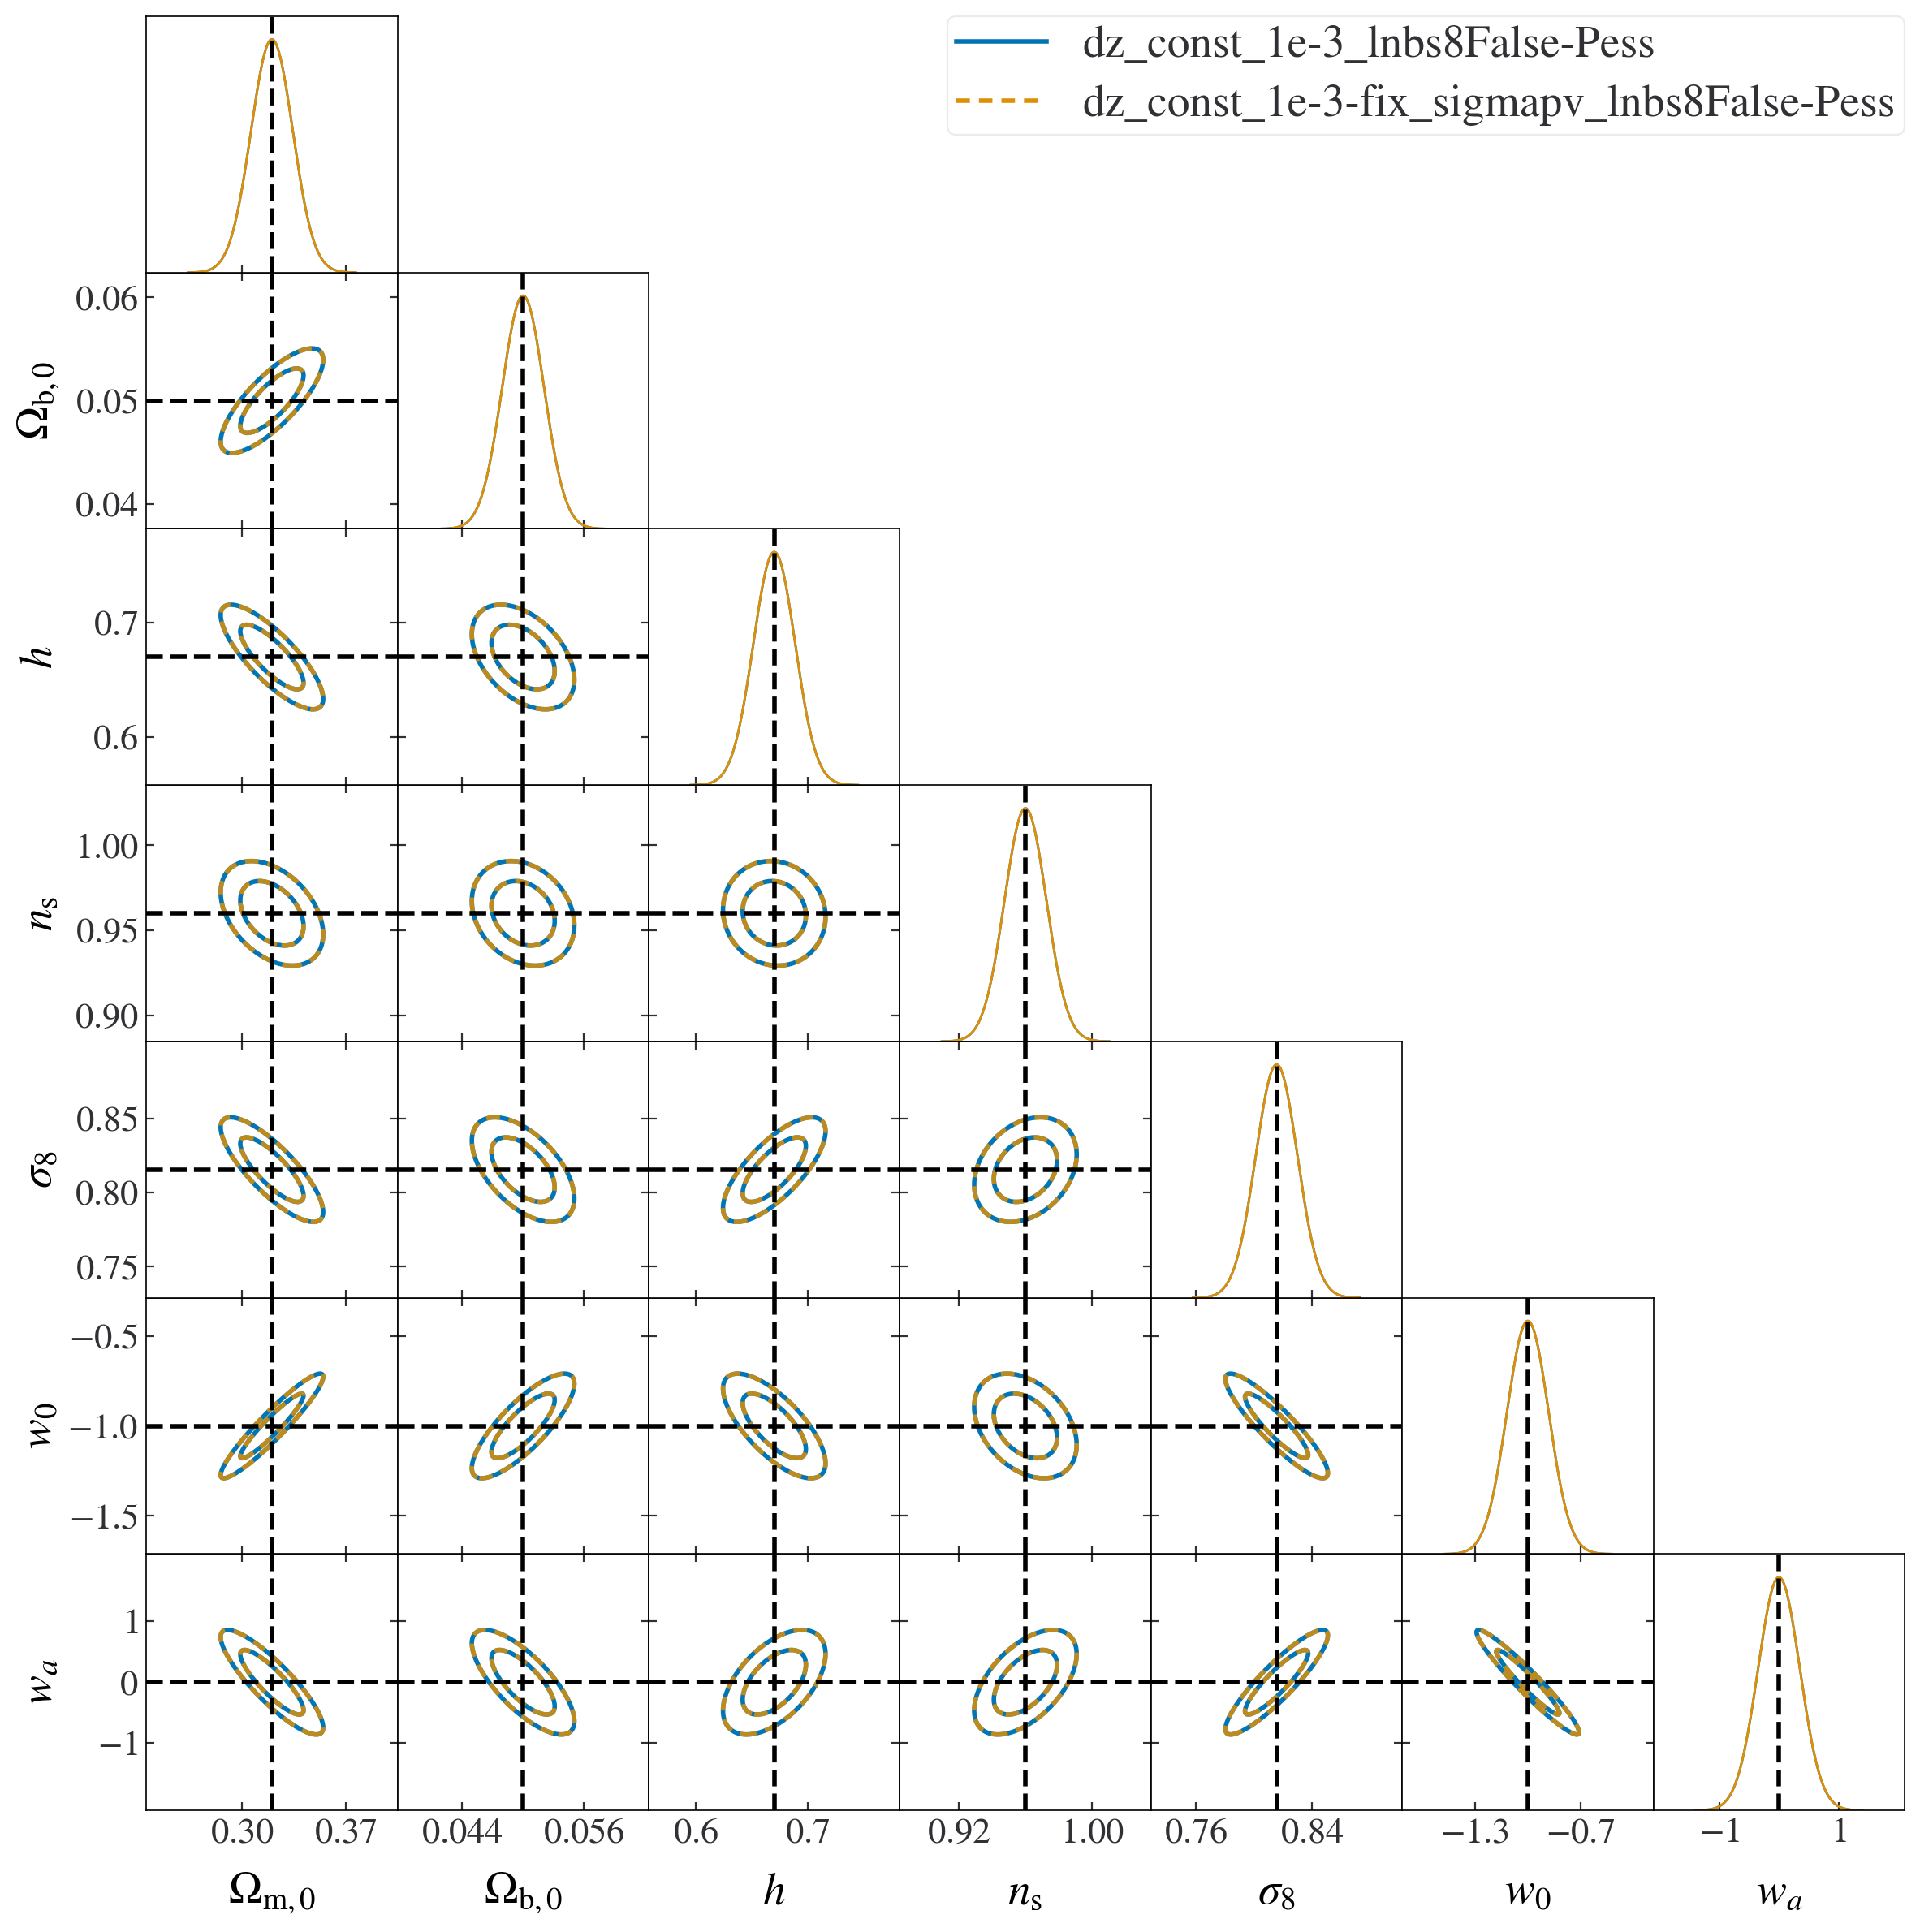

In [101]:
fish_plotter.plot_fisher(filled=False, contour_args=[{'alpha':0.99, 'ls': '-', 'lw':2.}, 
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.5},
                                                    {'alpha':0.85, 'ls' : '--', 'lw':2.}
                                                    ])